In [1]:
import utils
import numpy as np
from cv2 import *
import numpy as np
import matplotlib.pyplot as plt
import itertools as it


In [2]:
def box3d(n=16):
    points = []
    N = tuple(np.linspace(-1, 1, n))
    for i, j in [(-1, -1), (-1, 1), (1, 1), (0, 0)]:
        points.extend(set(it.permutations([(i, )*n, (j, )*n, N])))
    return np.hstack(points)/2

def projectpoints(K,R,t,Q):
    
    t = np.transpose([t])
    H = np.concatenate((R,t),axis=1)
    Q = PiInv(Q)

    return K@H@Q
def Pi(ph):
    p = ph[:-1]/ph[-1]
    return p

def PiInv(p):

    H = np.shape(p)[1]
    homo = np.ones((1, H))
    ph = np.concatenate((p,homo),axis = 0)
    return ph

def matrix(K,R,t):
    t = np.transpose([t])
    H = np.concatenate((R,t),axis=1)
    return K@H




In [3]:
# Exercise 2.1
f = 600
dx = 400
dy = 400
alpha = 1
beta = 0

K = np.array([[f, f*beta , dx],[0,f*alpha, dy],[0,0,1]])
R = np.diag([1,1,1])
t = np.array([0,0.2,1.5])
Q = np.array(box3d())



print(projectpoints(K,R,t,Q)[:,0])

print(matrix(K,R,t))



[100. 220.   1.]
[[600.    0.  400.  600. ]
 [  0.  600.  400.  720. ]
 [  0.    0.    1.    1.5]]


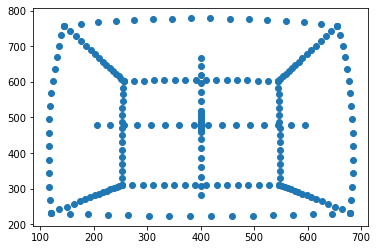

In [4]:
# Exercise 2.2

def delta_r(r,k3): 
    return k3*r**2

def project_distort(K,R,t,Q,k3):
    t = np.transpose([t])
    H = np.concatenate((R,t),axis=1)
    P = Pi(H@PiInv(Q))
    x = P[0,:]
    y = P[1,:]
    r = np.sqrt(x**2 + y**2)
    dist = 1 + k3*r**2
    undistorted_points = np.zeros_like(P)
    undistorted_points[0,:] = x * dist
    undistorted_points[1,:] = y * dist
    return K@PiInv(undistorted_points)

box = project_distort(K,R,t,Q,k3=-0.2)


plt.scatter(box[0],box[1])




In [23]:
# Exercise 2.3

import cv2

im = cv2.imread("gopro_robot.jpg")
im = im[:,:,::-1]
im = im.astype(float)/255

f = im.shape[1]*0.455732
deltax = im.shape[1]/2
deltay = im.shape[0]/2
alpha = 1
beta = 0

K = np.array([[f, f*beta , deltax],[0,f*alpha, deltay],[0,0,1]])

print(K)





[[875.00544   0.      960.     ]
 [  0.      875.00544 540.     ]
 [  0.        0.        1.     ]]


In [34]:
# Exercise 2.4


def undistortImage(im,K,k3,k5,k7):
    x, y = np.meshgrid(np.arange(im.shape[1]), np.arange(im.shape[0]))
    p = np.stack((x, y, np.ones(x.shape))).reshape(3, -1)

    q = Pi(np.linalg.inv(K)@p)

    x1 = q[0,:]
    y1 = q[1,:]
    r = np.sqrt(x1**2 + y1**2)
    dist = 1 + k3*r**2
    q_d = np.zeros_like(q)
    q_d[0,:] = x1 * dist
    q_d[1,:] = y1 * dist

    p_d = K@PiInv(q_d)

    x_d = p_d[0].reshape(x.shape).astype(np.float32)
    y_d = p_d[1].reshape(y.shape).astype(np.float32)

    assert (p_d[2]==1).all(), 'You did a mistake somewhere'
    im_undistorted = cv2.remap(im, x_d, y_d, cv2.INTER_LINEAR)
    return im_undistorted

k3=-0.245031
k5=0.071524
k7=-0.00994978
im_undistorted = undistortImage(im, K, k3, k5, k7)
im_undistorted = im_undistorted[:,:,::-1]
cv2.imshow("Undistorted Image", im_undistorted)



In [73]:
# Exercise 2.5
H = np.array([[-2, 0,1],[1,-2,0],[0,0,3]])
P = np.array([[1,1],[0,3],[2,3],[2,4]])
P = PiInv(P.T).T

for p in P:
    print(Pi(H@p))




[-0.33333333 -0.33333333]
[ 0.33333333 -2.        ]
[-1.         -1.33333333]
[-1. -2.]


In [102]:
# Exercise 2.6
def hest(q1,q2):
    Q1 = np.array([[0, -1, q1[1]],[1,0,-q1[0]],[-q1[1],q1[0],0]])
    B = np.kron(Q1,q2)
    U, S, V = np.linalg.svd(B)
    H = V[-1,:].reshape((3,3))
    return H

q1 = np.array([1,1])
q2 = np.array([0,3])


def hest1(q1, q2):
    N = q1.shape[1]
    A = np.zeros((2 * N, 9))
    for i in range(N):
        x, y = q1[0, i], q1[1, i]
        u, v = q2[0, i], q2[1, i]
        A[2 * i, :] = [x, y, 1, 0, 0, 0, -u * x, -u * y, -u]
        A[2 * i + 1, :] = [0, 0, 0, x, y, 1, -v * x, -v * y, -v]
    U, S, V = np.linalg.svd(A)
    H = V[-1, :].reshape((3, 3))
    return H

H = np.array([[-2, 0,1],[1,-2,0],[0,0,3]])
P = np.array([[1,0,2,2],[1,3,3,4]])

Q = Pi(H@PiInv(P))

print(hest1(P,Q)*4.35)

[[-4.58831468e-01 -1.14054254e-16  2.29415734e-01]
 [ 2.29415734e-01 -4.58831468e-01 -2.02614035e-17]
 [-3.10947911e-16  2.30285813e-16  6.88247202e-01]]
